In [1]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git &> /dev/null

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os, sys
import gymnasium as gym
import time
import text_flappy_bird_gym

import numpy as np
from tqdm import tqdm
import copy

import matplotlib.pyplot as plt
from matplotlib import axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

from utils import *

# Agent Class

In [4]:
from __future__ import print_function
from abc import ABCMeta, abstractmethod


class BaseAgent:

    __metaclass__ = ABCMeta

    def __init__(self):
        pass

    @abstractmethod
    def agent_init(self, agent_info= {}):
        """Setup for the agent called when the experiment first starts."""

    @abstractmethod
    def agent_start(self, observation):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            observation (Numpy array): the state observation from the environment's evn_start function.
        Returns:
            The first action the agent takes.
        """

    @abstractmethod
    def agent_step(self, reward, observation):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            observation (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """

    @abstractmethod
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the terminal state.
        """

    @abstractmethod
    def agent_cleanup(self):
        """Cleanup done after the agent ends."""

    @abstractmethod
    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent.
        Returns:
            The response (or answer) to the message.
        """

# Q-Learning Agent

In [5]:
class QLearningAgent(BaseAgent):
    def agent_init(self, agent_info): 
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        self.num_actions = agent_info["num_actions"]
        self.num_x = agent_info["num_states"][0]
        self.num_y = agent_info["num_states"][1]
        self.epsilon = agent_info["epsilon"]
        self.step_size = agent_info["step_size"]
        self.discount = agent_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        
        self.q = np.zeros((self.num_x, self.num_y, self.num_actions))

        
    def agent_start(self, x, y):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        # epsilon greedy.
        current_q = self.q[x, y, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q) 
        self.prev_x = x
        self.prev_y = y
        self.prev_action = action
        return action
    

    def agent_step(self, reward, x, y):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        # epsilon greedy.
        current_q = self.q[x, y, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # update
        self.q[self.prev_x, self.prev_y, self.prev_action] = (1 - self.step_size) * self.q[self.prev_x, self.prev_y, self.prev_action] + self.step_size * (reward + self.discount * self.q[x, y, action])
        
        self.prev_x = x
        self.prev_y = y
        self.prev_action = action
        return action
    

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        return((1 - self.step_size) * self.q[self.prev_x, self.prev_y, self.prev_action] + self.step_size * reward)
        

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        return(argmax(q_values))
    

    def agent_cleanup(self):         
        """Reset the agent's state after it has completed an episode."""
        self.last_state = None


    def agent_train(self, env, episodes = 100):
      """Train the agent in the given environment for a given number of episodes."""
      n_states = (env.observation_space[0].n * (env.observation_space[1].n + 1))
      num_actions = env.observation_space[1].n + 1
      self.train_episodes = episodes
      
      for i in tqdm(range(episodes)):
        obs = env.reset()
        x, y = get_state(obs)
        action = self.agent_start(x, y)
        
        is_done = False
        while not is_done:
            obs, reward, done, _, info = env.step(action)
            # If the episode is not done, update the agent's state and get the next action
            if not done:
                x, y = obs
                action = self.agent_step(reward, x, y)
            # If the episode is done, update the agent's state and end the episode
            else:
                self.agent_end(reward)
            is_done = done

100%|██████████| 40000/40000 [01:02<00:00, 635.03it/s]


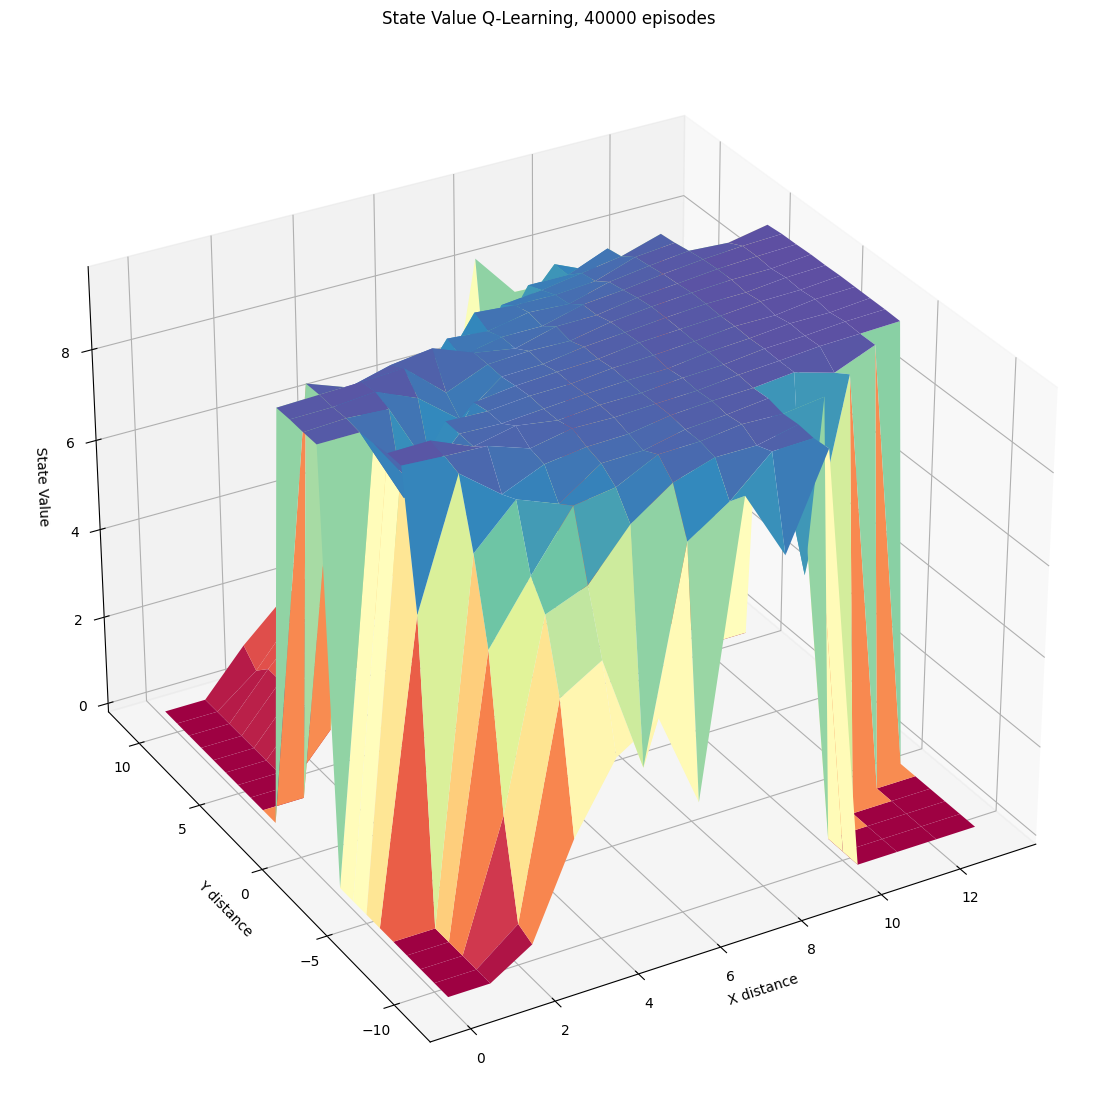

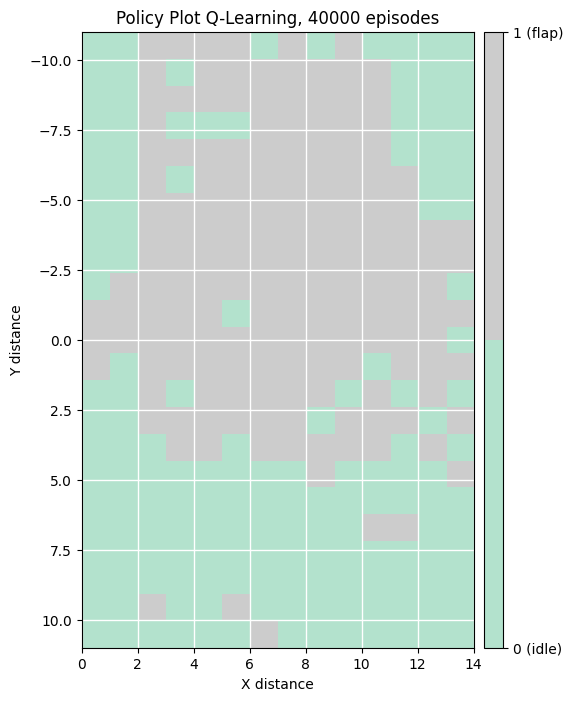

In [6]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

agent_info = {"num_actions": env.action_space.n,
              "num_states": (env.observation_space[0].n, env.observation_space[1].n + 1),
              "epsilon": 0.2,
              "step_size": 0.1,
              "discount": 0.9,
              "seed": 0}

episodes = 40000
Q_agent = QLearningAgent()
Q_agent.agent_init(agent_info)
Q_agent.agent_train(env, episodes = episodes)

plot_state_value(env, Q_agent, title = f'State Value Q-Learning, {episodes} episodes')
plot_policy(env, Q_agent, title = f'Policy Plot Q-Learning, {episodes} episodes')

In [7]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()
test_agent = copy.deepcopy(Q_agent)

obs = get_state(obs)

while True:
    print(test_agent.q[obs])
    action = argmax(test_agent.q[obs])

    obs, reward, done, _, info = env.step(action)

    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.4) # FPS

    # If player is dead break
    if done:
        break
    if info['score'] >= 100:
        break

    test_agent.agent_cleanup()
    env.close()

[9.59604012 9.57769195]
Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @             ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=-2)
[9.53065702 9.56444891]
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=-3)
[9.49003

# Expected SARSA Agent

In [8]:
class ExpectedSarsaAgent(BaseAgent):
    def agent_init(self, agent_info): 
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        self.num_actions = agent_info["num_actions"]
        self.num_x = agent_info["num_states"][0]
        self.num_y = agent_info["num_states"][1]
        self.epsilon = agent_info["epsilon"]
        self.step_size = agent_info["step_size"]
        self.discount = agent_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        
        self.q = np.zeros((self.num_x, self.num_y, self.num_actions))

        
    def agent_start(self, x, y):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        # epsilon greedy.
        current_q = self.q[x, y, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_x = x
        self.prev_y = y
        self.prev_action = action
        return action
    

    def agent_step(self, reward, x, y):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        # Epsilon greedy.
        current_q = self.q[x, y,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        self.policy = self.epsilon/self.num_actions * np.ones(self.num_actions)
        self.policy[self.argmax(current_q)] = 1 - self.epsilon + self.epsilon/self.num_actions
        sum = np.sum(current_q * self.policy)
        self.q[self.prev_x, self.prev_y, self.prev_action] += self.step_size * (reward + self.discount * sum - self.q[self.prev_x, self.prev_y, self.prev_action])

        self.prev_x = x
        self.prev_y = y
        self.prev_action = action
        return action
    

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        return((1 - self.step_size) * self.q[self.prev_x, self.prev_y, self.prev_action] + self.step_size * reward)
        

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []
        for i in range(len(q_values)):

            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)
    

    def agent_cleanup(self):         
        """Reset the agent's state after it has completed an episode."""
        self.last_state = None


    def agent_train(self, env, episodes = 100):
      """Train the agent in the given environment for a given number of episodes."""
      n_states = (env.observation_space[0].n * (env.observation_space[1].n + 1))
      num_actions = env.observation_space[1].n + 1
      self.train_episodes = episodes
      
      for i in tqdm(range(episodes)):
        obs = env.reset()
        x, y = get_state(obs)
        action = self.agent_start(x, y)
        
        is_done = False
        while not is_done:
            obs, reward, done, _, info = env.step(action)
            if not done:
                x, y = obs
                action = self.agent_step(reward, x, y)
            else:
                self.agent_end(reward)
            is_done = done

In [9]:
# Set up the environment with the specified parameters
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

# Set the agent's information with the environment parameters and learning rate
agent_info = {"num_actions": env.action_space.n,
              "num_states": (env.observation_space[0].n, env.observation_space[1].n + 1),
              "epsilon": 0.1, "step_size": 0.1,
              "discount": 1.0,
              "seed": 0}
SARSA_agent = ExpectedSarsaAgent()
SARSA_agent.agent_init(agent_info)

num_episodes = 40000
SARSA_agent.agent_train(env, episodes = num_episodes)

100%|██████████| 40000/40000 [03:16<00:00, 203.42it/s]


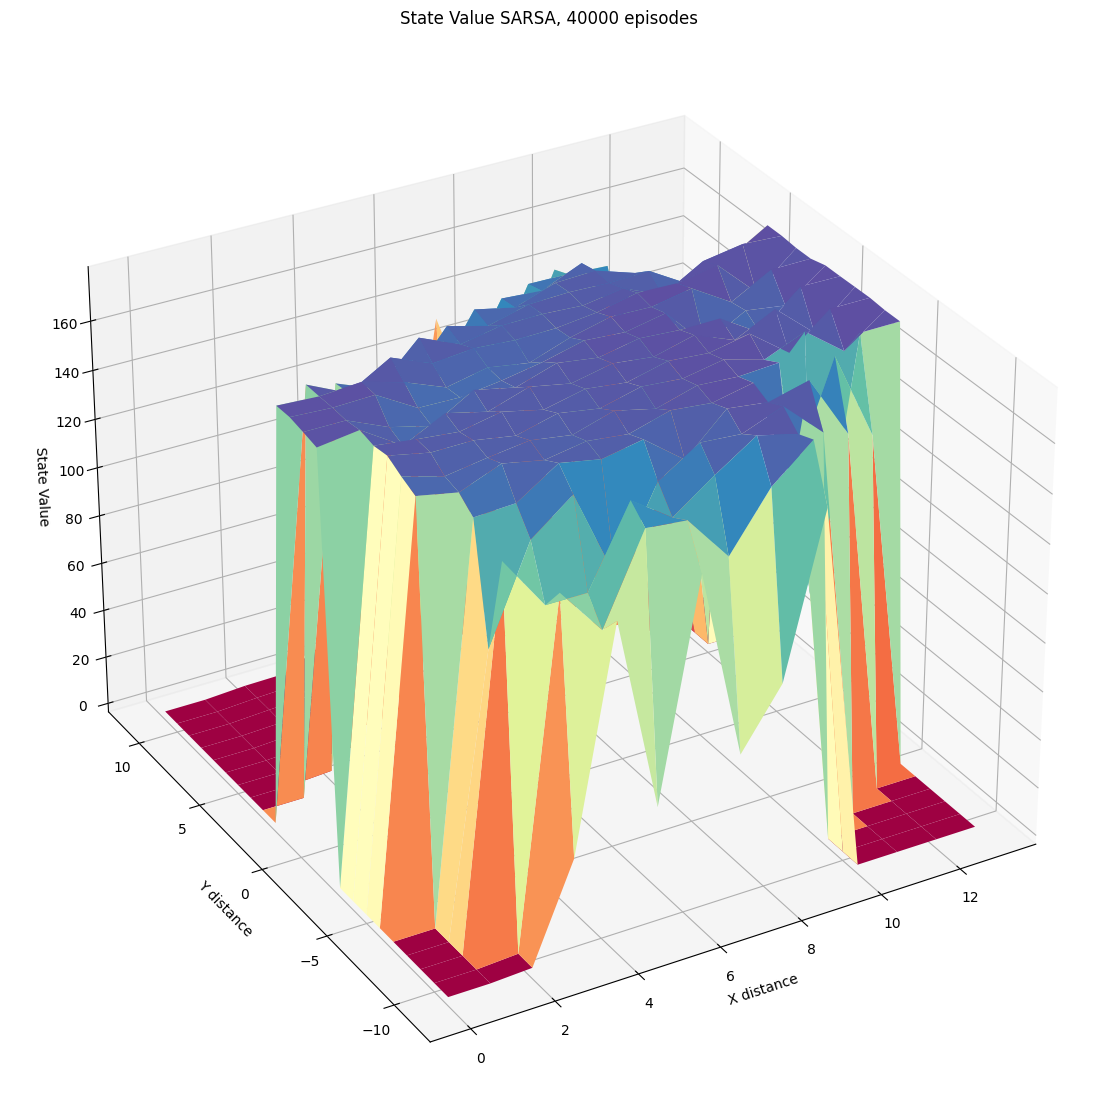

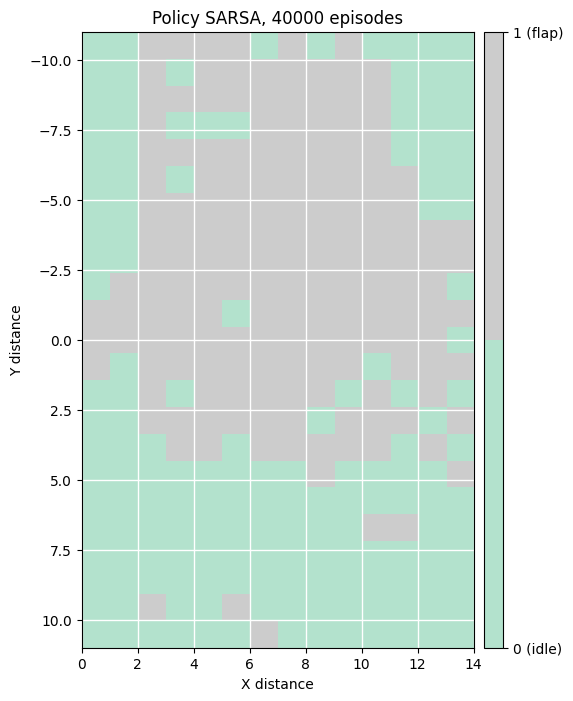

In [14]:
plot_state_value(env, SARSA_agent, title = f'State Value SARSA, {num_episodes} episodes')
plot_policy(env, Q_agent, title = f'Policy SARSA, {num_episodes} episodes')

In [10]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()
test_agent = copy.deepcopy(SARSA_agent)

obs = get_state(obs)

while True:
    print(test_agent.q[obs])
    action = argmax(test_agent.q[obs])

    # Apply action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    if done:
        break
    if info['score'] >= 100:
        break
    sys.stdout.write(env.render())

    test_agent.agent_cleanup()
    env.close()

[176.79416181 155.96805338]
Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
[      @           | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=3)
[147.02792055 177.70136742]
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=2)
[1

# Performances

In [11]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

agents = {'Q-Learning': QLearningAgent, 'SARSA': ExpectedSarsaAgent}
agent_info = {"num_actions": env.action_space.n,
              "num_states": (env.observation_space[0].n, env.observation_space[1].n + 1),
              "epsilon": 0.1,
              "step_size": 0.1,
              "discount": 1.0,
              "seed": 0}

n_runs = 100
n_episodes = 2000

all_rewards_sums = {}

for algorithm in agents.keys():
  agent = agents[algorithm]()
  all_rewards_sums[algorithm] = []

  for run in tqdm(range(n_runs)):
    agent_info['seed'] = run
    agent.agent_init(agent_info)

    reward_sums = []
    for episode in range(n_episodes):
      obs = env.reset()
      x, y = get_state(obs)
      action = agent.agent_start(x, y)
      
      sum = 0
      is_done = False
      while not is_done:
        obs, reward, done, _, info = env.step(action)
        
        if not done:
          x, y = obs
          action = agent.agent_step(reward, x, y)
          
        else:
          agent.agent_end(reward)
        
        sum += reward
        is_done = done
      
      reward_sums.append(sum)

    all_rewards_sums[algorithm].append(reward_sums)

100%|██████████| 100/100 [07:43<00:00,  4.64s/it]


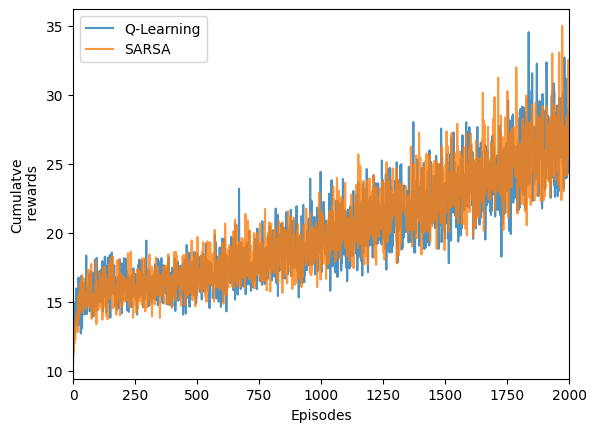

In [12]:
for algorithm in agents.keys():
    plt.plot(np.mean(all_rewards_sums[algorithm], axis = 0), label = algorithm, alpha = 0.8)
plt.xlabel("Episodes")
plt.ylabel("Cumulatve\n rewards")
plt.xlim(0, 2000)
plt.legend()
plt.show()

In [13]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
# n_states = (env.observation_space[0].n * (env.observation_space[1].n+1))
# n_y = env.observation_space[1].n+1

agents = {'Q-Learning':QLearningAgent, 'Expected SARSA': ExpectedSarsaAgent}
agent_info = {"num_actions": env.action_space.n,
              "num_states": (env.observation_space[0].n, env.observation_space[1].n + 1),
              "epsilon": 0.1,
              "step_size": 0.1,
              "discount": 1.0,
              "seed": 0}

n_runs = 20
n_episodes = 5000
step_sizes = [0.1, 0.3, 0.5, 0.8, 1]

all_rewards_sums = {}

for algorithm in agents.keys():
  agent = agents[algorithm]()
  
  for step_size in step_sizes:
    agent_info['step_size'] = step_size
    all_rewards_sums[(algorithm, step_size)] = []

    for run in tqdm(range(n_runs)):
      agent_info['seed'] = run
      agent.agent_init(agent_info)
      
      outter_sum = 0
      for episode in range(n_episodes):
        obs = env.reset()
        x, y = get_state(obs)
        action = agent.agent_start(x, y)
        
        inner_sum = 0
        is_done = False
        while not is_done:
          obs, reward, done, _, info = env.step(action)
          
          if not done:
            x, y = obs
            action = agent.agent_step(reward, x, y)
            
          else:
            agent.agent_end(reward)
          
          inner_sum += reward
          is_done = done
        
        outter_sum += inner_sum

      all_rewards_sums[(algorithm,step_size)].append(outter_sum/n_episodes)

100%|██████████| 20/20 [05:21<00:00, 16.07s/it]


In [20]:
def sem(arr):
    return np.std(arr) / np.sqrt(len(arr))

In [18]:
all_rewards_sums.keys()

dict_keys([('Q-Learning', 0.1), ('Q-Learning', 0.3), ('Q-Learning', 0.5), ('Q-Learning', 0.8), ('Q-Learning', 1), ('Expected SARSA', 0.1), ('Expected SARSA', 0.3), ('Expected SARSA', 0.5), ('Expected SARSA', 0.8), ('Expected SARSA', 1)])

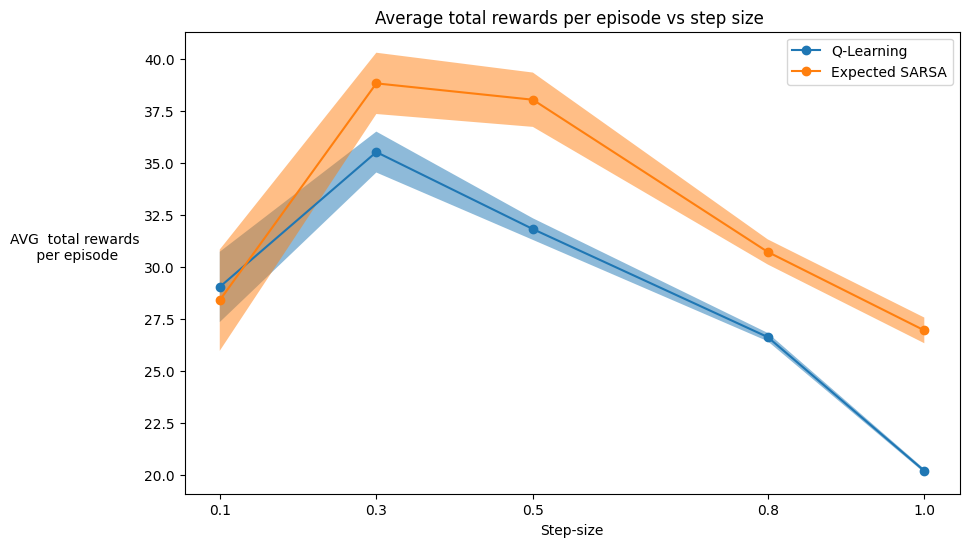

In [21]:
step_sizes = [0.1, 0.3, 0.5, 0.8, 1]
agents_list = ['Q-Learning','Expected SARSA']

plt.figure(figsize = (10,6))
for algorithm in agents_list:
    algorithm_means = np.array([np.mean(all_rewards_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([sem(all_rewards_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.5)

plt.legend()
plt.title('Average rewards per episode')
plt.xlabel("Step-size")
plt.ylabel("AVG rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)

plt.show()

In [ ]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

agents = {'Q-Learning':QLearningAgent, 'Expected SARSA': ExpectedSarsaAgent}
agent_info = {"num_actions": env.action_space.n,
              "num_states": (env.observation_space[0].n, env.observation_space[1].n + 1),
              "epsilon": 0.1,
              "step_size": 0.1,
              "discount": 1.0,
              "seed": 0}

n_runs = 20
n_episodes = 5000
epsilons = [0, 0.02, 0.1, 0.5]

all_rewards_sums = {}

for algorithm in agents.keys():
  agent = agents[algorithm]()
  
  for epsilon in epsilons:
    agent_info['epsilon'] = epsilon
    all_rewards_sums[(algorithm, epsilon)] = []

    for run in tqdm(range(n_runs)):
      agent_info['seed'] = run
      agent.agent_init(agent_info)
      
      reward_sums = []
      for episode in range(n_episodes):
        obs = env.reset()
        x, y = get_state(obs)
        action = agent.agent_start(x, y)
        
        inner_sum = 0
        is_done = False
        while not is_done:
          obs, reward, done, _, info = env.step(action)
          
          if not done:
            x, y = obs
            action = agent.agent_step(reward, x, y)
            
          else:
            agent.agent_end(reward)
          
          inner_sum += reward
          is_done = done
        
        reward_sums.append(inner_sum)

      all_rewards_sums[(algorithm,epsilon)].append(reward_sums)

100%|██████████| 20/20 [03:31<00:00, 10.59s/it]


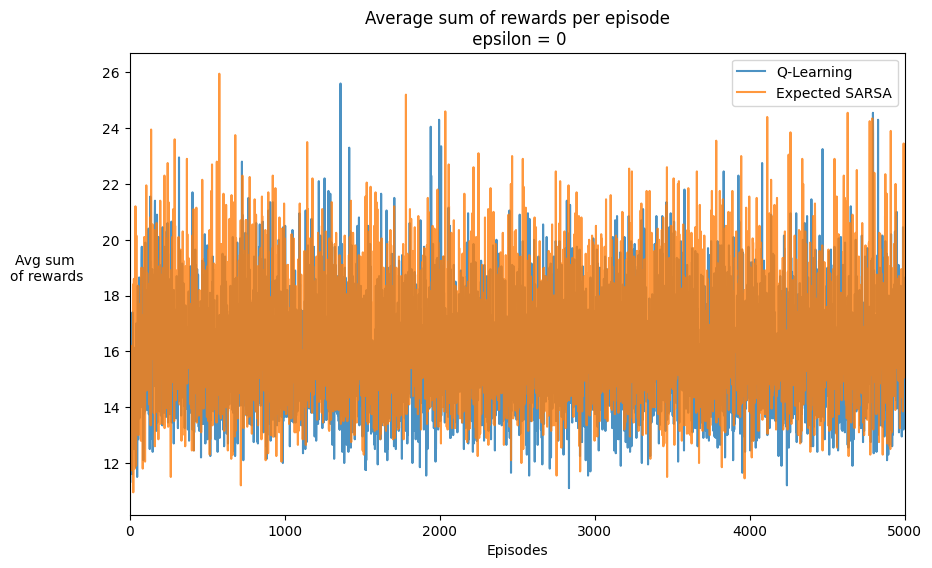

In [ ]:
eps = 0
plt.figure(figsize = (10,6))
for key in all_rewards_sums.keys():
  if key[1] == eps:
    plt.plot(np.mean(all_rewards_sums[key], axis=0), label=key[0], alpha = 0.8)
plt.xlabel("Episodes")
plt.ylabel("Avg sum \nof rewards",rotation=0, labelpad=40)
plt.title(f'Average sum of rewards per episode\n epsilon = {eps}')
plt.xlim(0,5000)
plt.legend()
plt.show()

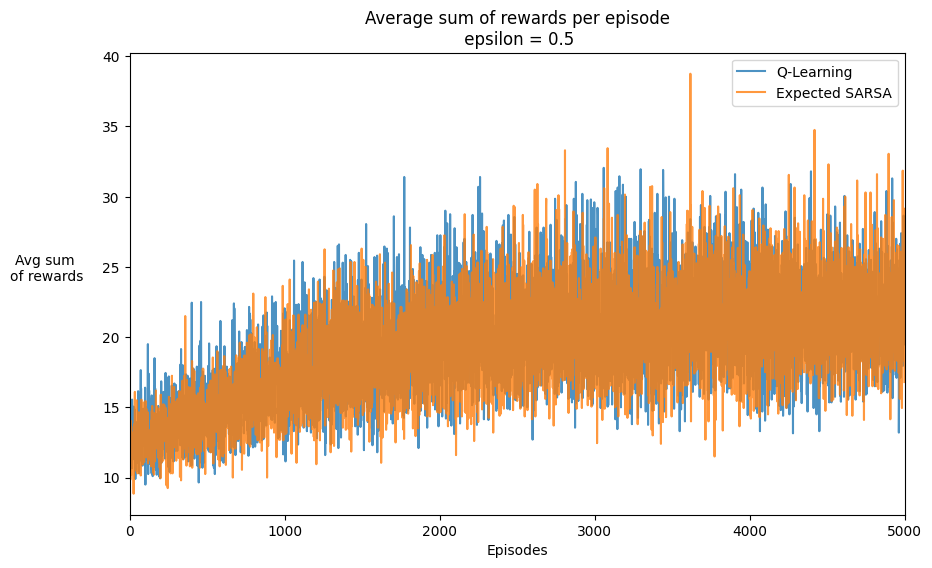

In [ ]:
eps = 0.5
plt.figure(figsize = (10,6))
for key in all_rewards_sums.keys():
  if key[1] == eps:
    plt.plot(np.mean(all_rewards_sums[key], axis=0), label=key[0], alpha = 0.8)
plt.xlabel("Episodes")
plt.ylabel("Avg sum \nof rewards",rotation=0, labelpad=40)
plt.title(f'Average sum of rewards per episode\n epsilon = {eps}')
plt.xlim(0,5000)
plt.legend()
plt.show()